In [2]:
import local_seqtools.general_utils as tools
import pandas as pd
import numpy as np
import local_conservation_analysis_pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"

# %load_ext autoreload
# %autoreload 2

# import score tables

In [6]:
def table_file_converter(table_file):
    return table_file.replace('/home/jch/Documents/08-benchmark', '..')

In [7]:
score_key_file = '../benchmark/benchmark_v4/p3_conservation/wide_form_tables_with_scores/score_key.csv'
score_key = pd.read_csv(score_key_file)
colmap = {
    'aln_property_entropy': 'property_entropy',
    'aln_shannon_entropy': 'shannon_entropy'
}
for i, row in score_key.iterrows():
    if row['score_key'] in colmap:
        score_key.at[i, 'columnwise_score_function_name'] = colmap[row['score_key']]

score_key = score_key.fillna('MSA')

def get_num_passing(table_file, score_key='hit_z_scores', filename_converter=None):
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    df = pd.read_csv(table_file)
    return (~df[score_key].isna()).sum()

score_key['num_passing'] = score_key['table_file'].apply(get_num_passing, filename_converter=table_file_converter)

In [11]:
score_key.head(10)

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,0.0,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2490
1,1.0,MSA - MAFFT,Tetrapoda,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2490
2,2.0,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644
3,3.0,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2644
4,4.0,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2474
5,5.0,MSA - MAFFT,Metazoa,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2474
6,6.0,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,shannon_entropy,2551
7,7.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2652
8,8.0,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2551
9,9.0,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2652


In [13]:
for i in score_key.score_key.unique(): print(i)

aln_property_entropy
aln_shannon_entropy
pairk_aln_lf5_rf5_edssmat50
pairk_aln_lf0_rf0_edssmat50
pairk_aln_lf5_rf5_blosum62
pairk_aln_lf0_rf0_blosum62
pairk_aln_lf0_rf0_grantham
pairk_aln_lf2_rf2_edssmat50
pairk_aln_lf10_rf10_edssmat50
pairk_aln_needleman_lf0_rf0_edssmat50
pairk_aln_embedding_lf5_rf5
pairk_aln_embedding_lf0_rf0


# filtering

a note on the Eukaryota phylogenetic level of homologs:

- Too many sequences get removed from the Eukaryota level when using MSA (because of the number of gaps in the alignment), so I will remove the eukaryota level from the Alignment.
Note that the scores of both methods drop when going from Metazoa to Euakryota, but the pairwise still performs better than the MSA.

## removing shannon entropy

In [12]:
score_key_filt=score_key[score_key['columnwise_score_function_name']=='property_entropy'].copy()

## remove alternate matrices and more unusual flank sizes

In [14]:
score_key_filt = score_key_filt[
    ~score_key_filt["score_key"].isin(
        [
            "pairk_aln_lf2_rf2_edssmat50",
            "pairk_aln_lf10_rf10_edssmat50",
            "pairk_aln_needleman_lf0_rf0_edssmat50",
            "pairk_aln_lf0_rf0_blosum62",
            "pairk_aln_lf5_rf5_blosum62",
            "pairk_aln_lf0_rf0_grantham",
        ]
    )
]

In [15]:
score_key_filt.score_key.unique()

array(['aln_property_entropy', 'pairk_aln_lf5_rf5_edssmat50',
       'pairk_aln_lf0_rf0_edssmat50', 'pairk_aln_embedding_lf5_rf5',
       'pairk_aln_embedding_lf0_rf0'], dtype=object)

# get scores

Set score_index as the dataframe index

In [16]:
# check if the column contains duplicates
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True) # verify_integrity checks for duplicates already

## import and merge scores into 1 table

In [17]:
def import_score_table(score_index_df, score_index, filename_converter=None):
    table_file = score_index_df.loc[score_index, 'table_file']
    if filename_converter is not None:
        table_file = filename_converter(table_file)
    return pd.read_csv(table_file)

def import_multiple_scores(score_index_df, score_index_list, score_colname='hit_z_scores', filename_converter=None):
    df = import_score_table(score_index_df, score_index_list[0], filename_converter=filename_converter)
    df=df[
        [
            'reference_index',
            'ELM_motif_class',
            'verified interaction',
            'regex',
            'UniprotID',
            'name',
            'gene_id',
            'hit end position',
            'hit start position',
            'hit_sequence',
            'json_file',
            score_colname,
        ]
    ]
    df = df.rename(columns={score_colname: score_index_list[0]})
    for score_index in score_index_list[1:]:
        df2 = import_score_table(score_index_df, score_index, filename_converter=filename_converter)
        df2 = df2[['reference_index', score_colname]]
        df2 = df2.rename(columns={score_colname: score_index})
        df = pd.merge(df, df2, on='reference_index', how='outer')
    return df

In [27]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(score_key_filt, score_indexes, filename_converter=table_file_converter)
zscores['ELM_motif_class'] = zscores['ELM_motif_class'].replace('enah_LPPPP_FPPPP', 'Ena/VASP ([FL]PPPP)')
zscores['hit_length'] = zscores['hit_sequence'].apply(len)

## position weights for average score of motif

Generate "weights" of all 1's for the 14-3-3 SLiM b/c the regex is variable length

In [28]:
temp = zscores[zscores['ELM_motif_class']=='LIG_14-3-3_CanoR_1'].copy()
l14_weights = {}
for l in temp['hit_length'].unique():
    l14_weights[l] = np.array([1.0]*l)

In [29]:
position_weights = {
    "DOC_WW_Pin1_4": np.array([0, 0, 0, 1, 1, 0]),  # ...([ST])P.
    "LIG_AP2alpha_2": np.array([1, 1, 1]),  # DP[FW]
    "LIG_EH_1": np.array([0, 1, 1, 1, 0]),  # .NPF.
    "LIG_SH2_GRB2like": np.array([1, 1, 1, 0]),  # (Y)([EDST]|[MLIVAFYHQW])N.
    "LIG_SH3_CIN85_PxpxPR_1": np.array([1, 0, 1, 0, 1, 1]),  # P.[AP].PR
    "Ena/VASP ([FL]PPPP)": np.array([1, 1, 0, 1, 1]),  # [FWYL]P.[AFILTVYWP]P
    "TRAF6": np.array([0,0,0,1,0,1,0,0,1]) # ...P.E..[FYWDE]
}# could use this for a weighted average score

In [30]:
zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)

## `passing_ref_id_list` - remove any entries that don't have valid values for all of the scores

In [31]:
zscores

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,...,28.0,29.0,32.0,33.0,36.0,37.0,40.0,41.0,hit_length,mask_array
0,0,LIG_AP2alpha_2,True,DP[FW],O08838,NaN,10116_0:004cdf,358,356,DPF,...,"[1.2646695131128232, -0.6230319877472846, 0.10...","[-0.232094903715352, -1.3636313814313115, 0.14...","[1.2696047329745765, 1.2696046696975787, 1.269...","[1.0471753033419202, 1.0471752261198142, 1.047...","[1.7222277382800255, 0.38123116719586625, 1.61...","[1.3524714755264853, -0.29264498028111596, 1.2...","[1.6172378689382068, -0.004036543445312039, -0...","[0.23105930001338953, -0.3787416170327342, -0....",3,"[1, 1, 1]"
1,1,LIG_AP2alpha_2,True,DP[FW],Q05140,NaN,10116_0:002e5e,401,399,DPF,...,"[0.8068631016990869, 0.6504573818486616, 1.619...","[0.7008197443957939, -1.0830474927114946, 1.41...","[1.207093398806528, 0.5259507945763567, 1.2070...","[0.8328283086902819, -0.02281529270853413, 0.8...","[1.9251912429957188, 0.10223100156938929, 1.73...","[1.1817071803751038, 0.589925492689403, 1.0596...","[1.258264193573611, 1.1496757113566374, 2.6748...","[0.04640706724253315, 0.6859607189691593, 1.56...",3,"[1, 1, 1]"
2,2,LIG_AP2alpha_2,True,DP[FW],Q05140,NaN,10116_0:002e5e,475,473,DPF,...,"[0.306919128843599, 0.5543636025383214, 2.1653...","[0.7008197443957939, -1.0830474927114946, 1.41...","[1.207093398806528, 0.431872830037263, 1.20709...","[0.8328283086902819, -0.02281529270853413, 0.8...","[1.9251912429957188, 1.3034901244952115, 1.738...","[1.1817071803751038, 0.6711255383390907, 0.966...","[1.0720470684871153, 1.6883719857552741, 2.692...","[0.0924741156040304, 0.6132790196506899, 1.553...",3,"[1, 1, 1]"
3,3,LIG_AP2alpha_2,True,DP[FW],P98082,NaN,9606_0:0016b2,294,292,DPF,...,"[3.662421085771397, 3.191840346290177, 4.11101...","[1.333318932125719, 0.9725999332709444, 1.3333...","[1.5134520973636345, 1.5134521208893905, 1.513...","[1.1358532147814893, 1.2821319445315111, 1.282...","[1.536108571675513, 2.0207482118537383, 2.0725...","[1.1392660802001298, 1.5196681776625272, 1.519...","[2.781162517517975, 2.392378459028744, 3.45897...","[1.7724211289988825, 1.7716131502560246, 2.007...",3,"[1, 1, 1]"
4,4,LIG_AP2alpha_2,True,DP[FW],P98082,NaN,9606_0:0016b2,299,297,DPF,...,"[2.7705513589276904, 1.0505947964105804, 2.262...","[1.333318932125719, 0.9725999332709444, 1.3333...","[1.6428897571312975, 1.5134521208893905, 1.642...","[1.1358532147814893, 1.2821319445315111, 1.282...","[1.9080676864765231, 1.7534638662105286, 0.842...","[1.3409143043396843, 1.4471762201201008, 0.735...","[1.836159111154244, 1.5134957352696496, 1.3488...","[1.807050324439477, 1.7874884432105909, 1.5714...",3,"[1, 1, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2967,2997,TRAF6,False,...P.E..[FYWDE],A0A5F9ZHS8,NaN,9606_0:00386f,1019,1011,IRDPSEFEY,...,"[0.04616922565127746, -0.48214384212047146, 0....","[-0.4176504473960754, -1.0653188817869024, -0....","[1.1838918317351264, -1.3050979436272176, 0.98...","[1.0511900713235667, -1.610073518708615, 0.972...","[1.2004547215172447, -0.6975244385279699, 0.07...","[1.1044239870958028, -0.8523430828599968, -0.0...","[0.15890907050610462, -0.29361149681625287, 0....","[-0.019770065129277075, -0.4682377577433382, 0...",9,"[0, 0, 0, 1, 0, 1, 0, 0, 1]"
2968,2998,TRAF6,False,...P.E..[FYWDE],P22087,NaN,9606_0:004480,117,109,NLVPGESVY,...,"[0.9313208579458524, 0.8265525658120287, 0.958...","[0.20538951050373389, 0.3070730423723289, 0.53...","[1.296296397825989, 1.5949452753401658, 1.5949...","[0.5587114461763083, 1.3274127066616475, 1.799...","[1.0853310354039019, 1.3478531942316123, 1.473...","[0.3728419857193394, 0.7614127202758839, 1.279...","[1.0066797238960365, 0.938918418529807, 1.1231...","[0.4370890348550323, 0.4927661999183488, 0.787...",9,"[0, 0, 0, 1, 0, 1, 0, 0, 1]"
2969,2999,TRAF6,False,...P.E..[FYWDE],Q92791,NaN,9606_0:003e0d,395,387,TEPPLEPED,...,"[-0.5361854725040386, 0.004001003887423297,

In [32]:
l = len(zscores)
print('require all benchmark entries to have all MSA entries')
zscores=zscores.dropna(subset=score_key_filt[score_key_filt['aln_type']=='MSA - MAFFT'].index).copy()
print(f'dropped {l-len(zscores)} entries')

require all benchmark entries to have all MSA entries
dropped 682 entries


In [33]:
zscores[score_indexes].apply(lambda x: list(x.dropna().index), axis=1).value_counts()

[0.0, 2.0, 4.0, 8.0, 9.0, 18.0, 24.0, 28.0, 29.0, 32.0, 33.0, 36.0, 37.0, 40.0, 41.0]    2261
[0.0, 2.0, 4.0, 9.0, 24.0, 29.0, 33.0, 37.0, 41.0]                                         29
Name: count, dtype: int64

In [34]:
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')

require all benchmark entries to have the other scores
 will drop:
29 entries
dropped 711 entries total


In [35]:
passing_ref_id_list = zscores['reference_index'].unique()
print(f'number of unique reference indexes: {len(passing_ref_id_list)}')

number of unique reference indexes: 2261


## convert the scores to lists (they are strings here)

In [36]:
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

# add the kibby scores to the table
see `../src/data_processing/BENCHMARK_processing/p5_kibby_conservation/`

In [37]:
def kibby_score_str_2_list(s):
    return np.array([float(x) for x in s.split(' ')])

In [38]:
kibby_score_file = '../benchmark/benchmark_v4/kibby_scores/gene_seqs_kibby_scores.csv'
kibby_df = pd.read_csv(kibby_score_file)
kibby_df['gene_id'] = kibby_df['header'].apply(lambda x: x.split('\t')[0])
kibby_df.conservation = kibby_df.conservation.apply(kibby_score_str_2_list)
kibby_df=kibby_df.drop(columns=['header'])
kibby_df

,sequence,conservation,gene_id
0,MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635...",10116_0:004cdf
1,MSGQTLTDRIAAAQYSVTGSAVARAVCKATTHEVMGPKKKHLDYLI...,"[0.4205, 0.2409, 0.12, 0.229, 0.1935, 0.2742, ...",10116_0:002e5e
2,MSNEVETSATNGQPDQQAAPKAPSKKEKKKGPEKTDEYLLARFKGD...,"[0.5946, 0.4162, 0.3126, 0.2569, 0.2155, 0.182...",9606_0:0016b2
3,MAAPLIPLSQQIPTGNSLYESYYKQVDPAYTGRVGASEAALFLKKS...,"[0.4822, 0.3428, 0.1583, 0.4239, 0.153, 0.1308...",9606_0:0044a5
4,MSTSSLRRQMKNIVHNYSEAEIKVREATSNDPWGPSSSLMSEIADL...,"[0.4792, 0.3475, 0.228, 0.2746, 0.2352, 0.3246...",10116_0:0002b6
...,...,...,...
2226,MDNCLAAAALNGVDRRSLQRSARLALEVLERAKRRAVDWHALERPK...,"[0.5362, 0.4713, 0.4293, 0.6061, 0.4001, 0.358...",9606_0:002bd4
2227,MTSLKRSQTERPLATDRASVVGTDGTPKVHTDDFYMRRFRSQNGSL...,"[0.5173, 0.3608, 0.296, 0.4211, 0.3774, 0.5792...",9606_0:003695
2228,MEGTHCTLQLHKPITELCYISFCLPKGEVRGFSYKGTVTLDRSNKG...,"[0.5233, 0.4451, 0.3636, 0.3349, 0.4269, 0.544...",9606_0:00386f
2229,MKPGFSPRGGGFGGRGGFGDRGGRGGRGGFGGGRGRGGGFRGRGRG...,"[0.5093, 0.4267, 0.541, 0.4354, 0.4546, 0.3233...",9606_0:004480


Merge with zscores

In [39]:
zscores=pd.merge(zscores, kibby_df, on='gene_id', how='left')

In [40]:
zscores.head(1)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,...,32.0,33.0,36.0,37.0,40.0,41.0,hit_length,mask_array,sequence,conservation
0,0,LIG_AP2alpha_2,True,DP[FW],O08838,NaN,10116_0:004cdf,358,356,DPF,...,"[1.2696047329745765, 1.2696046696975787, 1.269...","[1.0471753033419202, 1.0471752261198142, 1.047...","[1.7222277382800255, 0.38123116719586625, 1.61...","[1.3524714755264853, -0.29264498028111596, 1.2...","[1.6172378689382068, -0.004036543445312039, -0...","[0.23105930001338953, -0.3787416170327342, -0....",3,"[1, 1, 1]",MADIKTGIFAKNVQKRLNRAQEKVLQKLGKADETKDEQFEEYVQNF...,"[0.6059, 0.4469, 0.4653, 0.424, 0.5766, 0.4635..."


In [41]:
def extract_hit(s: pd.Series, colname: str):
    st = s['hit start position']
    end = s['hit end position']
    hit = s[colname][st:end+1]
    return hit

check that the hits are the same

In [42]:
zscores['hit2'] = zscores.apply(extract_hit, args=['sequence'], axis=1)
# zscores['kibby_hit_scores'] = zscores.apply(extract_hit, args=['conservation'], axis=1) # these aren't the z-scores
assert (zscores['hit2'] == zscores['hit_sequence']).all(), 'hit sequences from kibby are not all the same as the hit seqs in the table'

import the json to get the idr coordinates to calculate a z-score. Note that there are not gaps so no masking is needed.<br>

In [43]:
def get_kibby_zscores(json_file, scores, filename_converter=None):
    og = group_tools.ConserGene(json_file, filepath_converter=filename_converter)
    assert len(scores) == len(og.query_sequence)
    idr_scores=scores[og.idr_start:og.idr_end+1]
    assert len(idr_scores)==len(og.query_idr_sequence)
    z_scores=tools.z_score_comparison(scores, idr_scores)
    return z_scores

In [44]:
zscores['kibby_zscores'] = zscores.apply(lambda x: get_kibby_zscores(x['json_file'], x['conservation'], filename_converter=table_file_converter), axis=1)
zscores['kibby_hit_zscores'] = zscores.apply(extract_hit, args=['kibby_zscores'], axis=1)
zscores=zscores.drop(columns=['hit2', 'sequence', 'conservation', 'kibby_zscores'])
score_indexes.append('kibby_hit_zscores')

## add kibby to the score indexes

In [45]:
# temp=pd.DataFrame([['kibby_hit_zscores']+['kibby']*(len(score_key.columns)-1)], columns=score_key.columns)
temp = pd.DataFrame({'score_index': ['kibby_hit_zscores']*3, 'level': ['Metazoa', 'Tetrapoda', 'Vertebrata']}, columns=score_key.columns)
score_key2=pd.concat([score_key, temp], ignore_index=True).fillna('kibby')
score_key2.tail()

,score_index,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
40,40.0,Pairwise embedding,Metazoa,pairk_aln_embedding_lf5_rf5,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2732
41,41.0,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844
42,kibby_hit_zscores,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby
43,kibby_hit_zscores,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
44,kibby_hit_zscores,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby


Note that the kibby score is broadcast to each level

# export tables for bootstrapping analysis

In [46]:
score_key2.to_csv('./z_scores_score_key.csv', index=False)
zscores.to_csv('./z_scores_wideform.csv', index=False)

---

# get 1 score for each method for each entry - wide form
(average score of defined positions in SLiM based on the mask; no mask for 14-3-3, so all positions are used)

In [47]:
def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

In [48]:
# zscores['mask_array'] = zscores.apply(lambda x: position_weights[x['ELM_motif_class']] if x['ELM_motif_class'] in position_weights else l14_weights[x['hit_length']], axis=1)
zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)

# get 1 score for each method for each entry - long form

Melt the dataframe

In [49]:
id_cols = [
    'reference_index',
    'ELM_motif_class',
    'verified interaction',
    'regex',
    'UniprotID',
    'name',
    'gene_id',
    'hit end position',
    'hit start position',
    'hit_sequence',
    'json_file',
    'hit_length',
    'mask_array',
]
z_long = zscores.melt(id_vars=id_cols, value_vars=score_indexes, var_name='score_index', value_name='z_scores')

In [50]:
z_long['masked_z_scores'] = z_long.apply(lambda x: extract_important_scores(x, 'z_scores'), axis=1)
z_long['conservation_score'] = z_long['masked_z_scores'].apply(np.mean)
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
18093,5,LIG_AP2alpha_2,True,DP[FW],Q9UBC2,NaN,9606_0:0044a5,600,598,DPF,/home/jch/Documents/08-benchmark/benchmark/ben...,3,"[1, 1, 1]",29.0,"[1.1915060190690123, 1.0439605112095276, 1.006...","[1.1915060190690123, 1.0439605112095276, 1.006...",1.080529
22378,2692,Ena/VASP ([FL]PPPP),False,[FL]PPPP,E7EVG6,NaN,9606_0:0026f4,940,936,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",32.0,"[0.1667692996848771, 0.8092726826448482, 0.650...","[0.1667692996848771, 0.8092726826448482, 0.016...",0.456644
7227,561,LIG_EH_1,False,.NPF.,B3KWV4,NaN,9606_0:003d96,261,257,NNPFK,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[0, 1, 1, 1, 0]",8.0,"[-0.12457142019310806, 0.23140942498307757, 0....","[0.23140942498307757, 0.28530516626256586, 1.0...",0.518312
21327,1239,LIG_SH3_CIN85_PxpxPR_1,False,P.[AP].PR,A0A140VKF4,NaN,9606_0:001323,264,259,PSPAPR,/home/jch/Documents/08-benchmark/benchmark/ben...,6,"[1, 0, 1, 0, 1, 1]",32.0,"[0.5516002904124295, 1.2978753197754274, 1.634...","[0.5516002904124295, 1.634773081470226, -0.961...",0.064638
35840,2549,Ena/VASP ([FL]PPPP),False,[FL]PPPP,Q8WXD9,NaN,9606_0:003b3f,1194,1190,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",kibby_hit_zscores,"[-0.6530783719236646, 1.219941564597147, 0.778...","[-0.6530783719236646, 1.219941564597147, 2.537...",1.136023


In [51]:
z_long['score_index'].value_counts()

score_index
0.0                  2261
2.0                  2261
4.0                  2261
8.0                  2261
9.0                  2261
18.0                 2261
24.0                 2261
28.0                 2261
29.0                 2261
32.0                 2261
33.0                 2261
36.0                 2261
37.0                 2261
40.0                 2261
41.0                 2261
kibby_hit_zscores    2261
Name: count, dtype: int64

In [52]:
z_long['mask_array'].value_counts()

mask_array
[0, 1, 1, 1, 0]                                            5088
[1, 1, 1]                                                  4768
[1, 1, 1, 0]                                               4624
[1, 1, 0, 1, 1]                                            4528
[1, 0, 1, 0, 1, 1]                                         4480
[0, 0, 0, 1, 1, 0]                                         4304
[0, 0, 0, 1, 0, 1, 0, 0, 1]                                3648
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                             1408
[1.0, 1.0, 1.0, 1.0, 1.0]                                   848
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]               736
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                         688
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]          448
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]     352
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                    256
Name: count, dtype: int64

## remove TRAF6 (not enough true positives)

In [53]:
z_long_all = z_long.copy()
z_long = z_long[z_long['ELM_motif_class']!='TRAF6']

# basic score distribution at Metazoa

In [55]:
temp=pd.merge(z_long, score_key2, on='score_index', how='left')
temp = temp[(temp['rflank']!=5)].copy()
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'pairk_aln_lf0_rf0_edssmat50'])]
temp=temp[temp['level']=='Metazoa']
temp['reference_index'].value_counts().head(1)

reference_index
0    2
Name: count, dtype: int64

In [56]:
temp['score_key'].value_counts()

score_key
aln_property_entropy           2033
pairk_aln_lf0_rf0_edssmat50    2033
Name: count, dtype: int64

/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

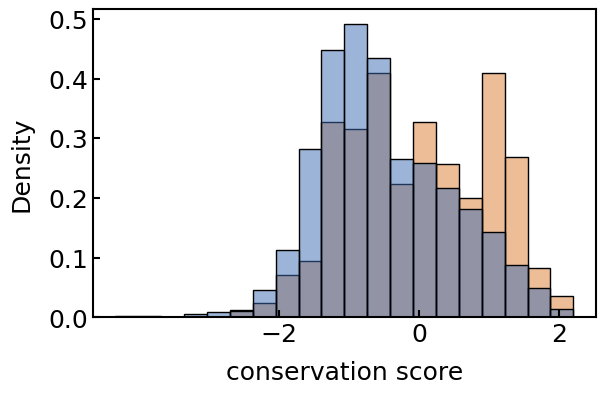

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

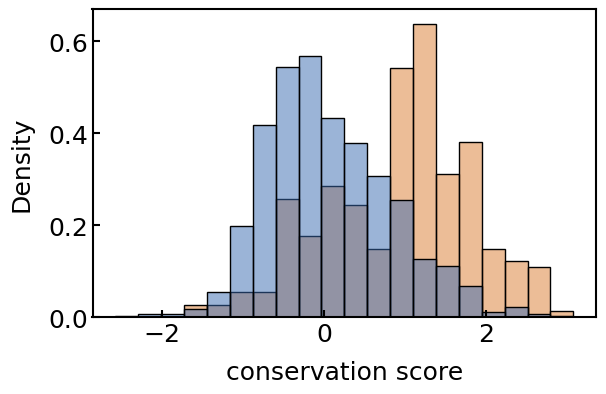

In [57]:
for i in temp['score_key'].unique():
    fig, ax = plt.subplots(figsize=(6.5, 4))
    sns.histplot(
        temp[temp['score_key']==i],
        x="conservation_score",
        hue="verified interaction",
        bins=20,
        stat="density",
        common_norm=False,
        ax=ax,
        legend=False,
    )
    ax.set_xticks([-2, 0, 2])
    ax.set_xlabel('conservation score')
    plt.savefig(f'./figure3/{i}_conservation_score_hist.png', bbox_inches='tight', dpi=300)
    # increase ymax by 0.1
    # ax.set_ylim(0, ax.get_ylim()[1]*1.1)

# basic score distributions vs. level

In [58]:
temp=pd.merge(z_long, score_key2, on='score_index', how='left')
temp = temp[(temp['rflank']!=5)].copy()
temp = temp[temp['score_key'].isin(['aln_property_entropy', 'pairk_aln_lf0_rf0_edssmat50'])]
temp['reference_index'].value_counts().head(1)

reference_index
0    6
Name: count, dtype: int64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

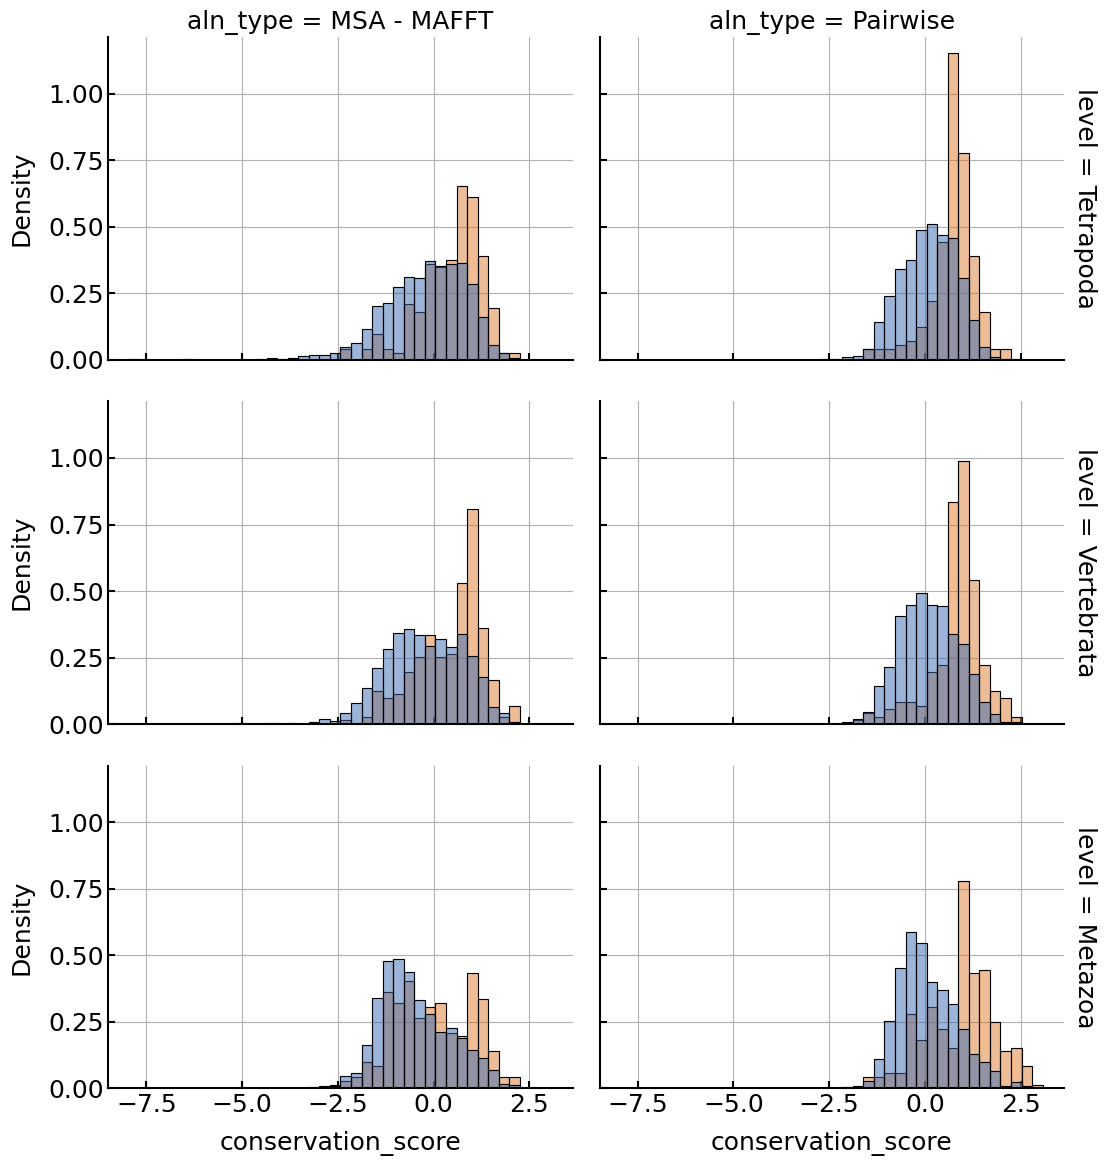

In [60]:
p = sns.displot(
    temp,
    x="conservation_score",
    hue="verified interaction",
    col="aln_type",
    row="level",
    bins=40,
    stat="density",
    common_norm=False,
    col_order=["MSA - MAFFT", "Pairwise"],#, "Pairwise embedding"],
    height=4,
    aspect=1.5,
    facet_kws=dict(margin_titles=True),
)
# plt.xlim([-3, 3])
p._legend.remove()
p.set_titles(f"Level: {{row_name}}\nAln type: {{col_name}}")
# show grid lines
for ax in p.axes.flat:
    ax.grid(True)
    ax.set_axisbelow(True)
output_folder = Path('./supplement/score_distributions')
output_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(output_folder / 'benchmark_score_distros_msa_v_pair.png', bbox_inches='tight', dpi=400)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

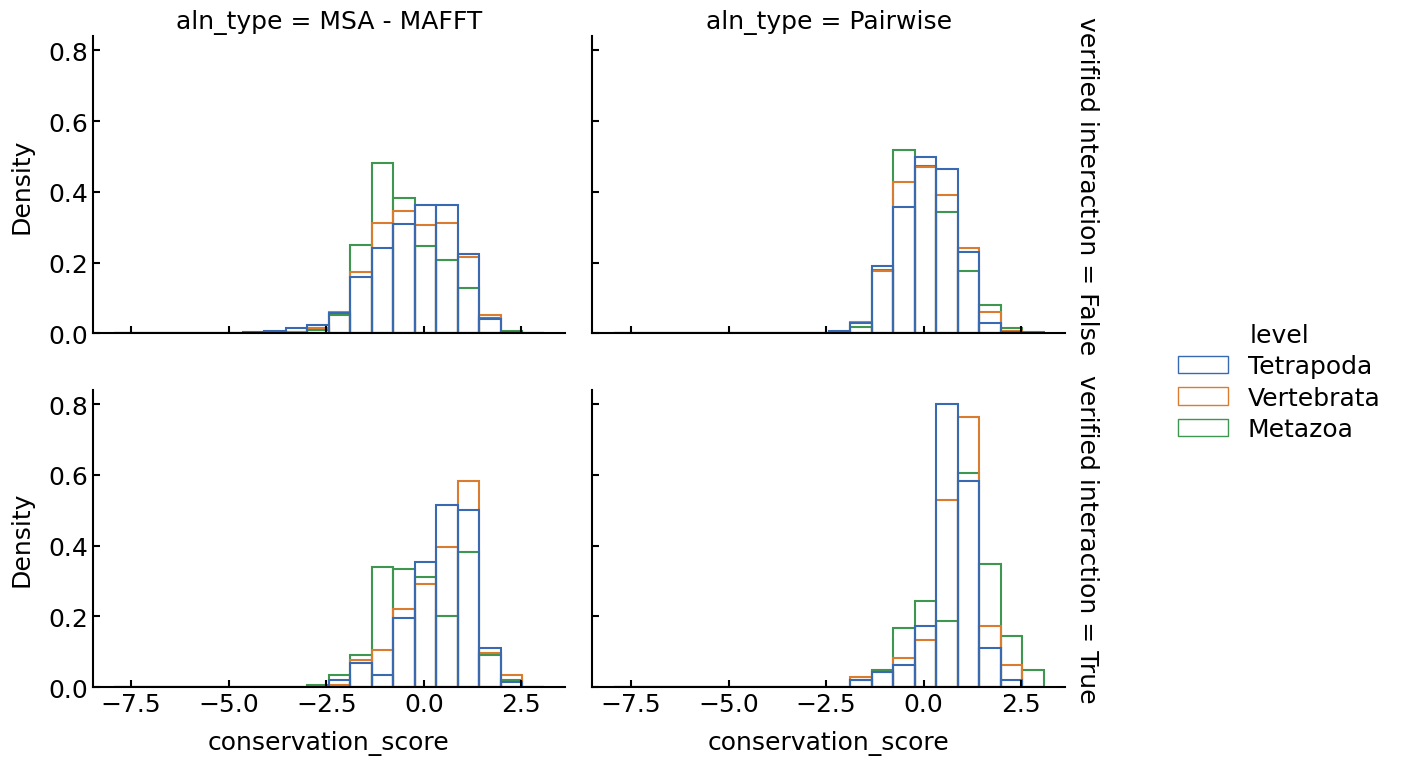

In [61]:
p = sns.displot(
    temp,
    x="conservation_score",
    hue="level",
    col="aln_type",
    row="verified interaction",
    bins=20,
    stat="density",
    common_norm=False,
    col_order=["MSA - MAFFT", "Pairwise"],#, "Pairwise embedding"],
    # row="columnwise_score_function_name",
    height=4,
    aspect=1.5,
    # multiple="stack",
    facet_kws=dict(margin_titles=True),
    legend=True,
    **dict(fill=False),
    # **dict(element='step'),
    # row_order=['Tetrapoda', 
)
# plt.xlim([-4, 4])
# p._legend.remove()
p.set_titles(f"Level: {{row_name}}\nAln type: {{col_name}}")
# show grid lines
# for ax in p.axes.flat:
#     ax.grid(True)
#     ax.set_axisbelow(True)

# auPRC dependence on variables - scoring matrix, flank size, columnwise score

In [62]:
score_key_filt = score_key[score_key['level'].isin(['Vertebrata'])].copy()
score_key_filt=score_key_filt.set_index('score_index', drop=True, verify_integrity=True)

In [63]:
score_indexes = list(score_key_filt.index)
zscores = import_multiple_scores(
    score_key_filt, score_indexes, filename_converter=table_file_converter
)
zscores['hit_length'] = zscores['hit_sequence'].apply(len)
zscores["ELM_motif_class"] = zscores["ELM_motif_class"].replace(
    "enah_LPPPP_FPPPP", "Ena/VASP ([FL]PPPP)"
)
zscores["mask_array"] = zscores.apply(
    lambda x: (
        position_weights[x["ELM_motif_class"]]
        if x["ELM_motif_class"] in position_weights
        else l14_weights[x["hit_length"]]
    ),
    axis=1,
)
l = len(zscores)
# starting with only the entries that are also present in the benchmark above
zscores=zscores[zscores['reference_index'].isin(passing_ref_id_list)].copy()
print(f'filtered out {l-len(zscores)} entries')
print('require all benchmark entries to have the other scores\n will drop:')
print(f'{zscores[score_indexes].isna().any(axis=1).sum()} entries')
zscores=zscores.dropna(subset=score_indexes).copy()
print(f'dropped {l-len(zscores)} entries total')
from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

filtered out 711 entries
require all benchmark entries to have the other scores
 will drop:
46 entries
dropped 757 entries total


In [64]:
id_cols = [
    "reference_index",
    "ELM_motif_class",
    "verified interaction",
    "regex",
    "UniprotID",
    "name",
    "gene_id",
    "hit end position",
    "hit start position",
    "hit_sequence",
    "json_file",
    "hit_length",
    "mask_array",
]
z_long = zscores.melt(
    id_vars=id_cols,
    value_vars=score_indexes,
    var_name="score_index",
    value_name="z_scores",
)
z_long["masked_z_scores"] = z_long.apply(
    lambda x: extract_important_scores(x, "z_scores"), axis=1
)
z_long["conservation_score"] = z_long["masked_z_scores"].apply(np.mean)
z_long=z_long[z_long["ELM_motif_class"] != "TRAF6"]
z_long.sample(5)

,reference_index,ELM_motif_class,verified interaction,regex,UniprotID,name,gene_id,hit end position,hit start position,hit_sequence,json_file,hit_length,mask_array,score_index,z_scores,masked_z_scores,conservation_score
44060,2678,Ena/VASP ([FL]PPPP),False,[FL]PPPP,P84550,NaN,9606_0:003749,581,577,LPPPP,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[1, 1, 0, 1, 1]",35.0,"[-0.8690785341468715, -0.18823750213209903, -0...","[-0.8690785341468715, -0.18823750213209903, -0...",-0.461481
31375,470,LIG_EH_1,False,.NPF.,O60481,NaN,9606_0:004e2a,40,36,LNPFG,/home/jch/Documents/08-benchmark/benchmark/ben...,5,"[0, 1, 1, 1, 0]",22.0,"[-0.20571637715708171, -1.4967637425835902, -1...","[-1.4967637425835902, -1.225879934038783, 0.00...",-0.904764
25680,1774,DOC_WW_Pin1_4,False,...([ST])P.,Q9NZM4,NaN,9606_0:0044a4,85,80,ILGSPA,/home/jch/Documents/08-benchmark/benchmark/ben...,6,"[0, 0, 0, 1, 1, 0]",19.0,"[1.1341880340567394, 1.3708314528578132, 0.614...","[-0.27897517768883895, -0.6527366225470946]",-0.465856
38971,1775,DOC_WW_Pin1_4,False,...([ST])P.,P39060,NaN,9606_0:004a6c,1537,1532,ILASPP,/home/jch/Documents/08-benchmark/benchmark/ben...,6,"[0, 0, 0, 1, 1, 0]",25.0,"[-1.2997145634645344, -0.11484344354899284, -1...","[-1.5654732411820174, -0.7328118029412496]",-1.149143
36051,791,LIG_SH2_GRB2like,True,(Y)([EDST]|[MLIVAFYHQW])N.,P35568,NaN,9606_0:000c08,898,895,YVNI,/home/jch/Documents/08-benchmark/benchmark/ben...,4,"[1, 1, 1, 0]",24.0,"[1.0566143167805826, 1.0566143809475497, 0.286...","[1.0566143167805826, 1.0566143809475497, 0.286...",0.800057


In [65]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key_filt, on='score_index', how='left')

In [66]:
auprc_df['score_key'].value_counts()

score_key
pairk_aln_lf5_rf5_edssmat50              14
pairk_aln_lf5_rf5_blosum62               14
pairk_aln_lf0_rf0_blosum62               14
pairk_aln_lf0_rf0_grantham               14
pairk_aln_lf2_rf2_edssmat50              14
pairk_aln_lf10_rf10_edssmat50            14
pairk_aln_lf0_rf0_edssmat50              14
pairk_aln_needleman_lf0_rf0_edssmat50    14
pairk_aln_embedding_lf5_rf5              14
pairk_aln_embedding_lf0_rf0              14
aln_property_entropy                      7
aln_shannon_entropy                       7
Name: count, dtype: int64

In [71]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[(temp['aln_type']!='Pairwise embedding')].copy()
temp = temp[(temp['columnwise_score_function_name']!='shannon_entropy')&(~temp['score_key'].isin(['pairk_aln_lf0_rf0_blosum62', 'pairk_aln_lf5_rf5_blosum62', 'pairk_aln_lf0_rf0_grantham', 'pairk_aln_needleman_lf0_rf0_edssmat50']))].copy()
temp['lflank'] = temp['lflank'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp['score_key'].value_counts()

score_key
aln_property_entropy             7
pairk_aln_lf5_rf5_edssmat50      7
pairk_aln_lf2_rf2_edssmat50      7
pairk_aln_lf10_rf10_edssmat50    7
pairk_aln_lf0_rf0_edssmat50      7
Name: count, dtype: int64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

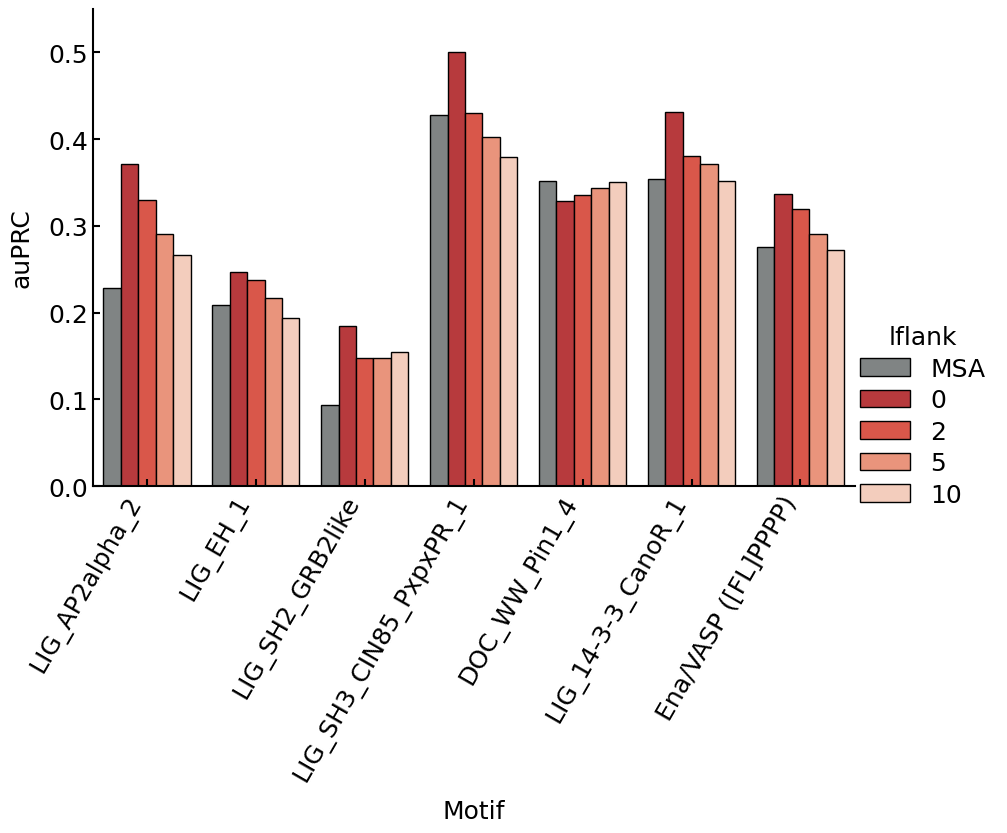

In [72]:
# temp = temp[(temp['columnwise_score_function_name']=='property_entropy')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="lflank",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'MSA',
        '0',
        '2',
        '5',
        '10',
    ],
    palette={
        'MSA':'#7f8585',
        '0': '#cc2529',
        # '0': '#FCC9B4',
        '2': '#F14432',
        '5': '#FB8A6A',
        '10': '#FCC9B4',
        # '10': '#BB1419',
    },
)
plot.set(ylim=(0.0, 0.55))
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot._legend.remove()
plot.set_xlabels('Motif')
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'flank-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [73]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
].copy()
temp = temp[temp["columnwise_score_function_name"] != "shannon_entropy"].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "pairk_aln_lf0_rf0_edssmat50",
            "pairk_aln_lf0_rf0_grantham",
            "pairk_aln_lf0_rf0_blosum62",
        ]
    )
].copy()

In [74]:
temp.score_key.value_counts()

score_key
pairk_aln_lf0_rf0_blosum62     7
pairk_aln_lf0_rf0_grantham     7
pairk_aln_lf0_rf0_edssmat50    7
Name: count, dtype: int64

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name

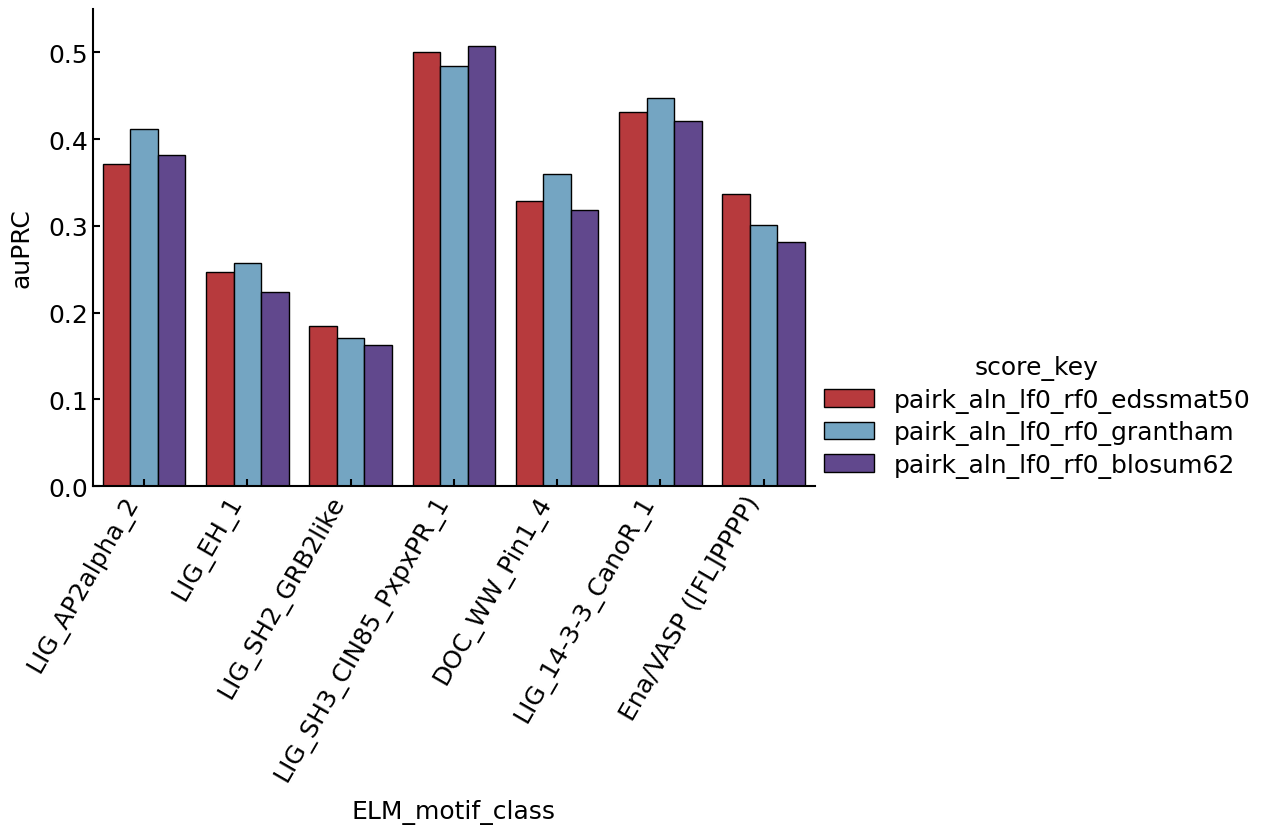

In [77]:
# fig, ax = plt.subplots(figsize=(10, 6))

plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    hue_order=[
        "pairk_aln_lf0_rf0_edssmat50",
        "pairk_aln_lf0_rf0_grantham",
        "pairk_aln_lf0_rf0_blosum62",
    ],
    palette={
        "pairk_aln_lf0_rf0_edssmat50":'#cc2529',
        "pairk_aln_lf0_rf0_grantham": '#67a9cf',
        "pairk_aln_lf0_rf0_blosum62": '#5e3c99',
        # "pairk_aln_lf0_rf0_blosum62": '#ef8a62',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'matrices-PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

In [78]:
temp = auprc_df.copy()
temp = temp[
    (temp["aln_type"] != "Pairwise embedding")
].copy()
temp=temp[
    temp["score_key"].isin(
        [
            "pairk_aln_lf0_rf0_edssmat50",
            "aln_shannon_entropy",
            "aln_property_entropy",
        ]
    )
].copy()
temp['score_index'] = temp['score_index'].apply(lambda x: str(int(x)) if isinstance(x, float) else x)
temp.score_key.value_counts()

score_key
pairk_aln_lf0_rf0_edssmat50    14
aln_property_entropy            7
aln_shannon_entropy             7
Name: count, dtype: int64

In [79]:
temp

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
0,LIG_AP2alpha_2,2,0.228765,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644
1,LIG_AP2alpha_2,3,0.244391,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2644
8,LIG_AP2alpha_2,16,0.404108,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2822
16,LIG_AP2alpha_2,24,0.371688,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2822
22,LIG_EH_1,2,0.208653,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644
23,LIG_EH_1,3,0.196494,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2644
30,LIG_EH_1,16,0.224186,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,shannon_entropy,2822
38,LIG_EH_1,24,0.247302,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2822
44,LIG_SH2_GRB2like,2,0.093953,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2644
45,LIG_SH2_GRB2like,3,0.085759,MSA - MAFFT,Vertebrata,aln_shannon_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,shannon_entropy,2644


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jch/mambaforge/envs/slim_conservation/lib/python3.12/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.g

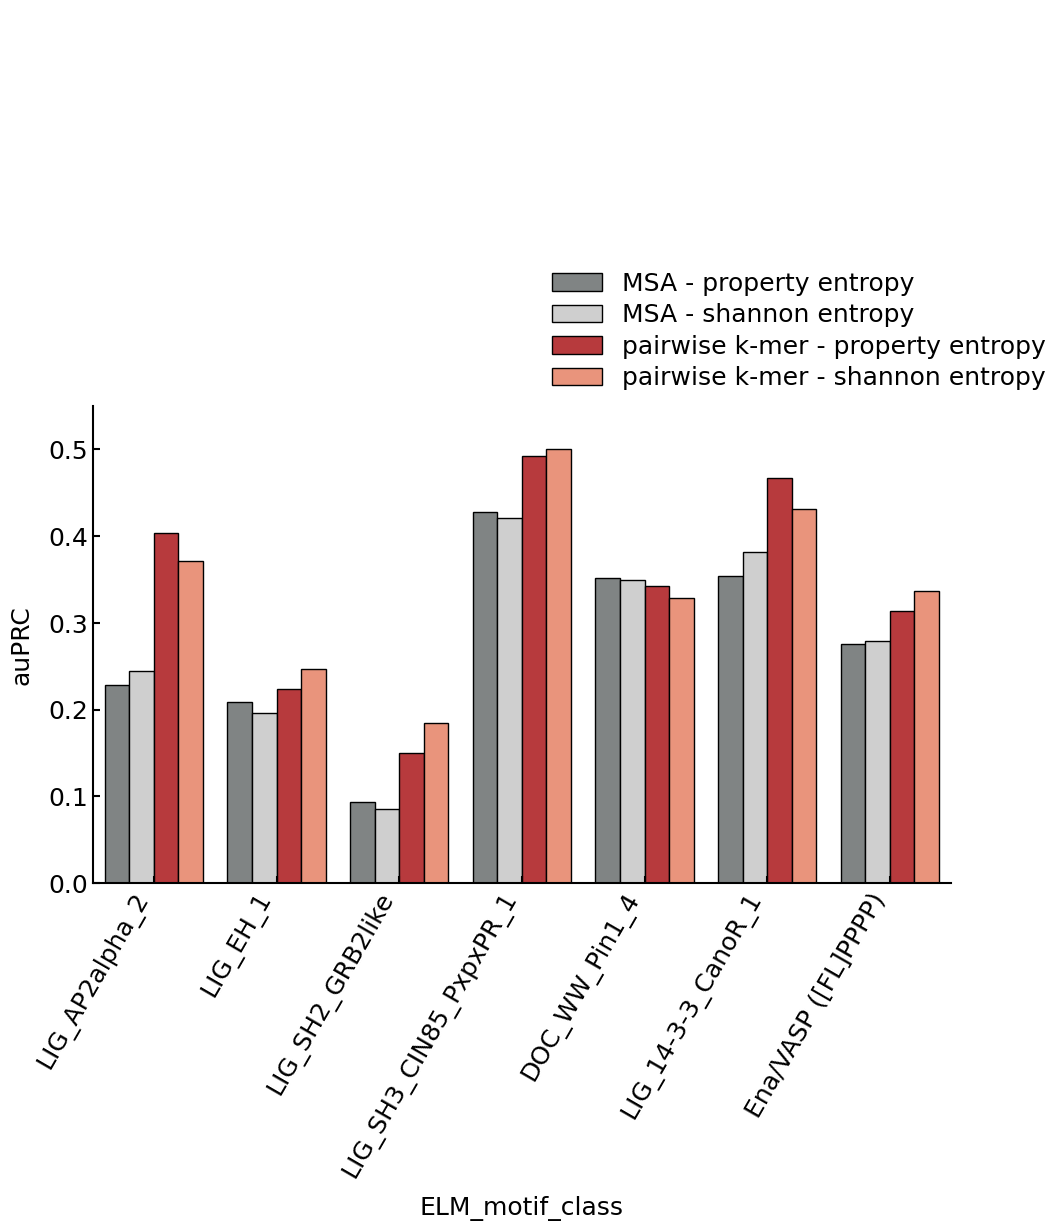

In [81]:
# fig, ax = plt.subplots(figsize=(10, 6))
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_index",
    hue_order=['2', '3','16', '24'],
    palette={
        '2':'#7f8585',
        '3':'#cfcfcf',
        '16':'#cc2529',
        '24':'#FB8A6A',
        # "shannon_entropy": '#5e3c99',
        # "fragpair_gapless_lf0_rf0_blosum62": '#ef8a62',
    },
    kind="bar",
    height=6,
    aspect=1.5,
    legend=True,
    # ax=ax,
)

# set the legend labels
plot._legend.set_title('')
new_labels = ['MSA - property entropy', 'MSA - shannon entropy', 'pairwise k-mer - property entropy', 'pairwise k-mer - shannon entropy']
for t, l in zip(plot._legend.texts, new_labels): t.set_text(l)
# move the legend outside the plot
plot._legend.set_bbox_to_anchor((1, 1.5))
plt.tight_layout()


plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plt.xticks(rotation=60, horizontalalignment="right")
# ax.set_ylim([0, 0.55])
# set y limits
plot.set(ylim=(0.0, 0.55))
# plot._legend.remove()
supp_folder = Path('./supplement/')
output_folder = supp_folder / 'performance_of_pairwise_variants'
output_folder.mkdir(exist_ok=True, parents=True)
plt.savefig(output_folder / 'shannon_v_PE-rbm_f-_vertebrata.png', bbox_inches='tight', dpi=400)

# auPRC - see `bootstrapping_auprc_scores.ipynb` for final plots

## general

In [45]:
score_inds, auprc_list = [], []
for i in z_long['score_index'].unique():
    df_filtered = z_long[z_long['score_index']==i].copy()
    assert df_filtered['reference_index'].duplicated().sum()==0, 'duplicates in reference index'
    prc_results = tools.df_2_precision_recall_curve(df_filtered, 'verified interaction', 'conservation_score')
    score_inds.append(i)
    auprc_list.append(prc_results[3])
general_auprc_df = pd.DataFrame({'score_index': score_inds, 'auPRC': auprc_list})

In [44]:
general_auprc_df=pd.merge(general_auprc_df, score_key2, on='score_index', how='left')

In [45]:
general_auprc_df

,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing
0,0.0,0.224889,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2362
1,2.0,0.228150,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2524
2,4.0,0.210868,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/07-pt1_pt2_combined/benchm...,MSA,MSA,MSA,property_entropy,MSA,2343
3,8.0,0.244820,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2445
4,9.0,0.268706,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2541
5,12.0,0.259915,Pairwise,Tetrapoda,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448
6,13.0,0.276281,Pairwise,Tetrapoda,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544
7,21.0,0.257537,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,True,property_entropy,1.0,2602
8,27.0,0.289127,Pairwise,Vertebrata,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,True,property_entropy,1.0,2703
9,35.0,0.266125,Pairwise,Vertebrata,fragpair_gapless_lf5_rf5_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605


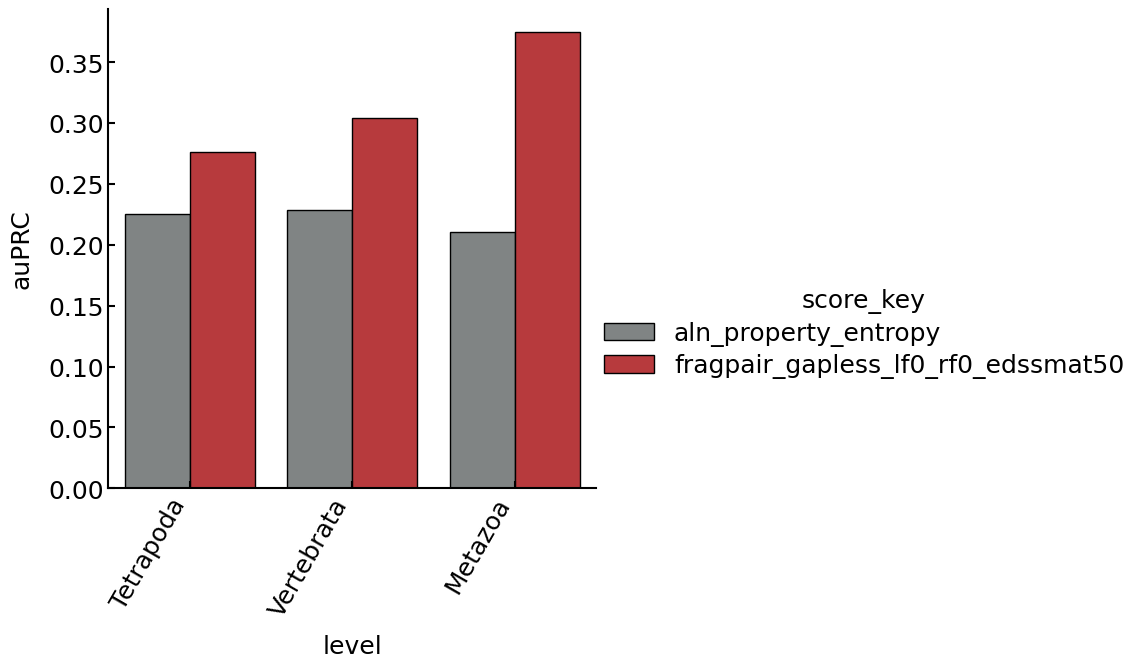

In [72]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
        & (general_auprc_df['reciprocal_best_match']!=True)
    ],
    y="auPRC",
    hue='score_key',
    x='level',
    kind='bar',
    aspect=1.2,
    height=6,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        # 'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'kibby',
    ],
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set(ylim=(0.0, 0.45))


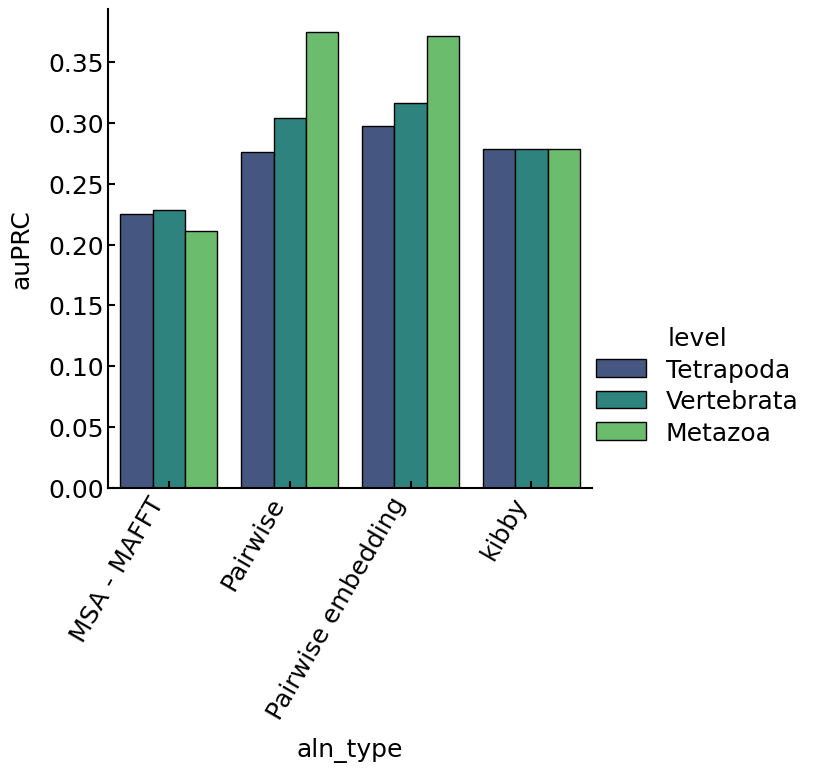

In [47]:
plot = sns.catplot(
    data=general_auprc_df[
        (general_auprc_df['rflank']!=5)
        & (general_auprc_df['reciprocal_best_match']!=True)
    ],
    y="auPRC",
    x='aln_type',
    hue='level',
    kind='bar',
    aspect=1.1,
    height=6,
    palette='viridis',
)
plot.set_xticklabels(rotation=60, horizontalalignment="right")

## per class

In [46]:
classes = list(z_long['ELM_motif_class'].unique())
class_list, score_inds, auprc_list = [], [], []
scores = z_long['score_index'].unique()
for cl in classes:
    for c, i in enumerate(z_long['score_index'].unique()):
        df_filtered = z_long[z_long['score_index']==i]
        df_copy = df_filtered[df_filtered['ELM_motif_class'] == cl].copy()
        prc_results = tools.df_2_precision_recall_curve(df_copy, 'verified interaction', 'conservation_score')
        class_list.append(cl)
        score_inds.append(i)
        auprc_list.append(prc_results[3])
auprc_df = pd.DataFrame({'ELM_motif_class': class_list, 'score_index': score_inds, 'auPRC': auprc_list})
auprc_df = pd.merge(auprc_df, score_key2, on='score_index', how='left')

aln_df=auprc_df[auprc_df['aln_type']=='MSA - MAFFT'][["ELM_motif_class", "auPRC", "level"]].copy()
auprc_df_norm=pd.merge(auprc_df, aln_df, on=['ELM_motif_class', 'level'], how='left', suffixes=('', '_aln'))

auprc_df_norm["auPRC_diff"] = auprc_df_norm["auPRC"] - auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_increase"] = auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_log_increase"] = np.log10(
    auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
)
auprc_df_norm.tail(10)

,ELM_motif_class,score_index,auPRC,aln_type,level,score_key,table_file,lflank,rflank,reciprocal_best_match,columnwise_score_function_name,similarity_threshold,num_passing,auPRC_aln,auPRC_diff,auPRC_increase,auPRC_log_increase
158,Ena/VASP ([FL]PPPP),49.0,0.299614,Pairwise,Metazoa,fragpair_gapless_lf0_rf0_edssmat50,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.238577,0.061037,1.255840,0.098934
159,Ena/VASP ([FL]PPPP),52.0,0.263915,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2448,0.267478,-0.003563,0.986680,-0.005824
160,Ena/VASP ([FL]PPPP),53.0,0.267287,Pairwise embedding,Tetrapoda,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2544,0.267478,-0.000191,0.999287,-0.000310
161,Ena/VASP ([FL]PPPP),56.0,0.290489,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2605,0.266770,0.023720,1.088915,0.036994
162,Ena/VASP ([FL]PPPP),57.0,0.290179,Pairwise embedding,Vertebrata,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2706,0.266770,0.023409,1.087751,0.036530
163,Ena/VASP ([FL]PPPP),60.0,0.332579,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf5_rf5,/home/jch/Documents/07-pt1_pt2_combined/benchm...,5.0,5.0,False,property_entropy,1.0,2619,0.238577,0.094002,1.394014,0.144267
164,Ena/VASP ([FL]PPPP),61.0,0.310252,Pairwise embedding,Metazoa,frag_pairwise_gapless_embedding_lf0_rf0,/home/jch/Documents/07-pt1_pt2_combined/benchm...,0.0,0.0,False,property_entropy,1.0,2723,0.238577,0.071676,1.300430,0.114087
165,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.238577,0.129718,1.543715,0.188567
166,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.267478,0.100817,1.376915,0.138907
167,Ena/VASP ([FL]PPPP),kibby_hit_zscores,0.368294,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,kibby,kibby,0.266770,0.101525,1.380571,0.140059


In [47]:
temp['ELM_motif_class'].unique()

array(['LIG_AP2alpha_2', 'LIG_EH_1', 'LIG_SH2_GRB2like',
       'LIG_SH3_CIN85_PxpxPR_1', 'DOC_WW_Pin1_4', 'LIG_14-3-3_CanoR_1',
       'Ena/VASP ([FL]PPPP)'], dtype=object)

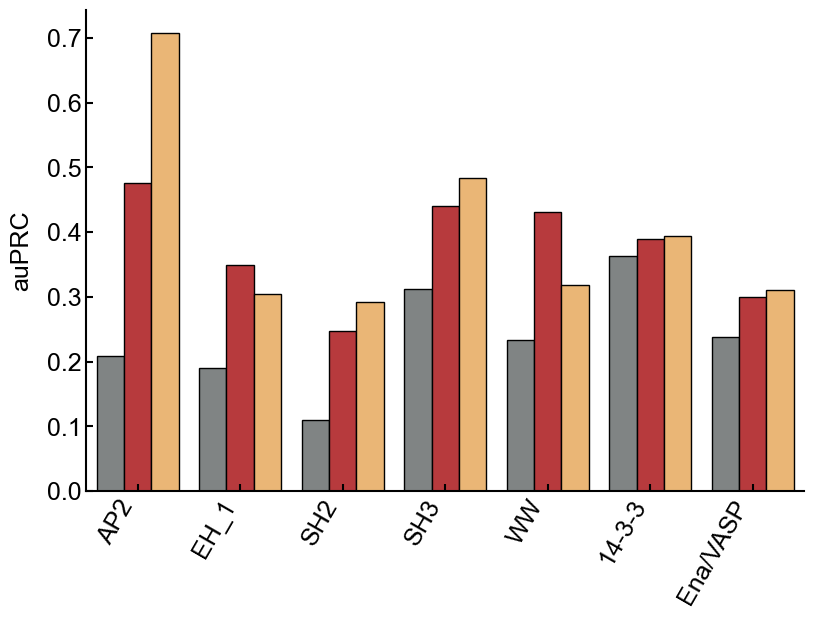

In [50]:
# temp = auprc_df_norm[auprc_df_norm['ELM_motif_class']!='TRAF6']
plt.rcParams['axes.labelsize'] = 18
temp = auprc_df_norm.copy()
temp = temp[(temp['level']=='Metazoa')&(temp['reciprocal_best_match'].isin([False, 'MSA', 'kibby']))].copy()
temp = temp[temp['rflank']!=5]
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('Ena/VASP ([FL]PPPP)', 'Ena/VASP')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_AP2alpha_2', 'AP2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_EH_1', 'EH_1')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH2_GRB2like', 'SH2')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_SH3_CIN85_PxpxPR_1', 'SH3')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('DOC_WW_Pin1_4', 'WW')
temp['ELM_motif_class'] = temp['ELM_motif_class'].replace('LIG_14-3-3_CanoR_1', '14-3-3')
plot = sns.catplot(
    data=temp,
    x="ELM_motif_class",
    y="auPRC",
    hue="score_key",
    kind="bar",
    height=6,
    aspect=1.5,
    hue_order=[
        'aln_property_entropy',
        'fragpair_gapless_lf0_rf0_edssmat50',
        'frag_pairwise_gapless_embedding_lf0_rf0',
        # 'kibby',
    ],
    # col="lflank",
    # row='level',
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'fragpair_gapless_lf0_rf0_edssmat50': '#cc2529', 'frag_pairwise_gapless_embedding_lf0_rf0':'#fdb863'},
)
# make tick labels smaller
plot.set_xticklabels(rotation=60, horizontalalignment="right")
# plot.set_xticklabels(rotation=60, horizontalalignment="right", fontsize=14)
# plot.set_yticklabels(fontsize=18)
plot._legend.remove()
plot.set_xlabels('')
# plt.ylim([0, 0.5])
# plt.tight_layout()
# plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)